In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math

In [2]:
df = pd.read_csv('./kaggle/city_hour.csv')
df

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707870,Visakhapatnam,2020-06-30 20:00:00,9.50,36.00,2.75,25.57,15.85,4.57,0.62,NaN,27.75,NaN,NaN,NaN,51.0,Satisfactory
707871,Visakhapatnam,2020-06-30 21:00:00,17.25,49.25,3.62,33.20,20.62,3.78,0.76,2.02,25.58,NaN,NaN,NaN,51.0,Satisfactory
707872,Visakhapatnam,2020-06-30 22:00:00,36.00,71.00,2.20,30.80,18.20,3.67,0.58,1.77,26.15,NaN,NaN,NaN,50.0,Good
707873,Visakhapatnam,2020-06-30 23:00:00,15.75,63.00,1.02,28.90,16.00,3.80,0.49,0.75,15.82,NaN,NaN,NaN,50.0,Good


In [3]:
df.dropna()
dfd = df.loc[ df['City'] == 'Delhi']  #will be using the delhi data first for simplicity
dfd = dfd.loc[dfd['Datetime'] < '2016-01-01 00:00:00']
dfd = dfd.dropna()

In [4]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4949 entries, 245187 to 253930
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        4949 non-null   object 
 1   Datetime    4949 non-null   object 
 2   PM2.5       4949 non-null   float64
 3   PM10        4949 non-null   float64
 4   NO          4949 non-null   float64
 5   NO2         4949 non-null   float64
 6   NOx         4949 non-null   float64
 7   NH3         4949 non-null   float64
 8   CO          4949 non-null   float64
 9   SO2         4949 non-null   float64
 10  O3          4949 non-null   float64
 11  Benzene     4949 non-null   float64
 12  Toluene     4949 non-null   float64
 13  Xylene      4949 non-null   float64
 14  AQI         4949 non-null   float64
 15  AQI_Bucket  4949 non-null   object 
dtypes: float64(13), object(3)
memory usage: 657.3+ KB


In [5]:
data = dfd
data['y'] = data['AQI']
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4949 entries, 245187 to 253930
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        4949 non-null   object 
 1   Datetime    4949 non-null   object 
 2   PM2.5       4949 non-null   float64
 3   PM10        4949 non-null   float64
 4   NO          4949 non-null   float64
 5   NO2         4949 non-null   float64
 6   NOx         4949 non-null   float64
 7   NH3         4949 non-null   float64
 8   CO          4949 non-null   float64
 9   SO2         4949 non-null   float64
 10  O3          4949 non-null   float64
 11  Benzene     4949 non-null   float64
 12  Toluene     4949 non-null   float64
 13  Xylene      4949 non-null   float64
 14  AQI         4949 non-null   float64
 15  AQI_Bucket  4949 non-null   object 
 16  y           4949 non-null   float64
dtypes: float64(14), object(3)
memory usage: 696.0+ KB


In [6]:

x = data.iloc[:, 2:15].values
y = data.iloc[:, 16].values
print(y)

[456. 450. 446. ... 432. 433. 435.]


In [7]:
split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (3959, 13) trainY: (3959,)
testX: (990, 13) testY: (990,)


In [8]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

In [9]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    return x_, y_

In [10]:
train_x_slide, train_y_slide = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} ')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape}')


train_x: torch.Size([3956, 3, 13]) train_y: torch.Size([3956, 4, 1]) 
test_x: torch.Size([987, 3, 13]) test_y: torch.Size([987, 4, 1])


In [11]:
class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware


        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1
        
        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out


In [12]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 13
learning_rate = 0.004
num_epochs = 42

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_slide), batch_size = batch_size, shuffle = False)

modelQ = QRegressionLSTM(num_sensors=13, hidden_units= 12, n_qubits=4)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))


weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [13]:
histQ = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_Q = []
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)
        output = torch.cat([y[:, :3, :], output.reshape(-1, 1, 1)], axis = 1)
        label = torch.ones_like(y).to(device)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        loss_Q.append(lossQ.item()) 
    histQ[epoch] = sum(loss_Q)  
    print(f'[{epoch+1}/{num_epochs}]  LossG:{sum(loss_Q)}')

ValueError: Weights tensor must have last dimension of length 5; got 4

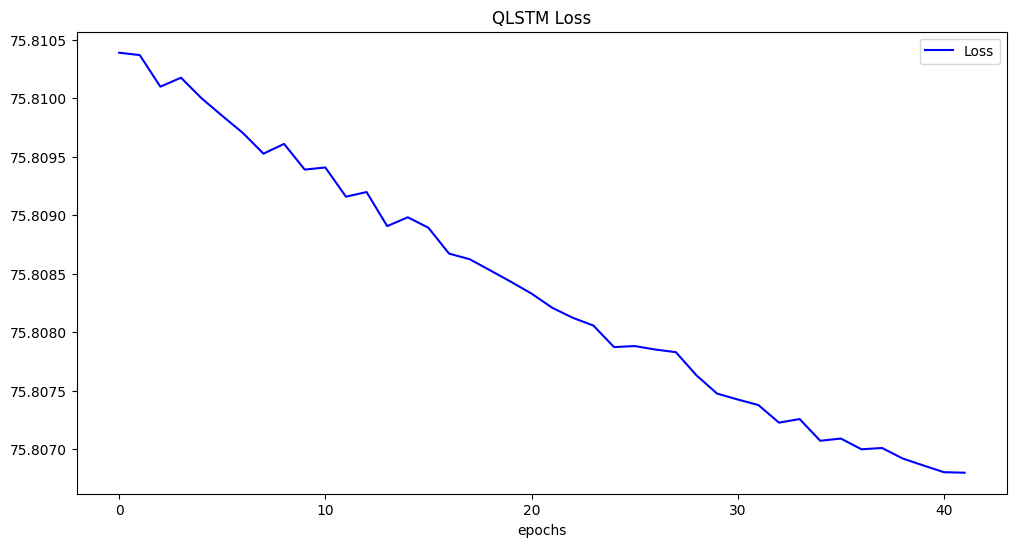

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')